Files already downloaded and verified
Files already downloaded and verified
cuda:0
获取一些随机训练数据


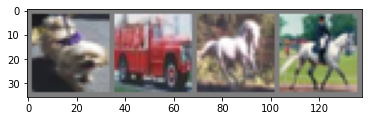

  dog truck horse horse
**********************


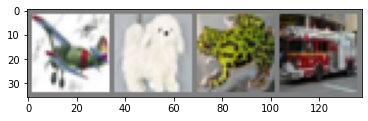

Modle file load successful !
训练
[1,  2000] loss: 0.383745
[1,  4000] loss: 0.370070
[1,  6000] loss: 0.318320
[1,  8000] loss: 0.393058
[1, 10000] loss: 0.491861
[1, 12000] loss: 0.424688
Save Model!
[2,  2000] loss: 0.300858


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim import *


PATH = './train.pth'  # 保存模型地址

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

print("获取一些随机训练数据")
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print("**********************")

# 设置一个tensorborad
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))    

# 设置tensorBoard
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('tensoarboard/train')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
# matplotlib_imshow(img_grid, one_channel=True)
imshow(img_grid)

# write to tensorboard
# writer.add_image('imag_classify', img_grid)

# Tracking model training with TensorBoard
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    # preds = np.squeeze(preds_tensor.numpy())
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

#

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 2000, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2000, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 88)
        self.fc3 = nn.Linear(88, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
# # 把net结构可视化出来
writer.add_graph(net, images)
net.to(device)

try:
    net.load_state_dict(torch.load(PATH))
    print("Modle file load successful !")
except:
    print("no model file,it will creat a new file!")

# 训练
print("训练")
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#在发现loss不再降低或者acc不再提高之后，降低学习率。
optimizer = torch.optim.SGD(net.parameters(), lr=0.0009575, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.35,verbose=1,min_lr=0.0001,patience=85)

# optimizer.to(device)   #wrong using
# scheduler.to(device)   #wrong using

startTime = datetime.now()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad() #将参数的grad值初始化为0

        # forward + backward + optimize
        outputs = net(inputs)
        outputs.to(device)
        loss = criterion(outputs, labels) #计算损失
        loss.to(device)
        loss.backward() # 反向传播
        optimizer.step() # 反向传播求梯度

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            now_loss = running_loss / 2000 # 2000mini-batches 的平均损失率
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, now_loss))
            # now_loss = running_loss / 2000
            
            scheduler.step(now_loss)

                        # 把数据写入tensorflow
            # ...log the running loss
            writer.add_scalar('image training loss on net width 2000 chang_lr_by_decrease',
                            now_loss,
                            epoch * len(trainloader) + i)

            writer.add_scalar('learning rate on net width 2000 chang_lr_by_decrease',
                            optimizer.state_dict()['param_groups'][0]['lr'],
                            epoch * len(trainloader) + i)                            

            running_loss = 0.0
    if epoch % 5 == 0: #每5次保存一下模型
        torch.save(net.state_dict(), PATH)
        print('Save Model!')


torch.save(net.state_dict(), PATH)

print('Finished Training And save Model !')
print("***************************")
print("***************************")
print("***************************")
print("Time taken:", datetime.now() - startTime)
print("***************************")
print("***************************")
print("***************************")



#获取一些随机测试数据
print("获取一些随机测试数据")
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 恢复模型并测试
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

print("**********************")
print("输出训练得到的准确度")
# 输出训练得到的准确度
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
#  tensorboard --logdir=runs/train